In [3]:
from functools import reduce
# from itertools import islice
import math
# import pickle

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
spark = pyspark.sql.SparkSession(sc)

In [4]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.77232725, -2.64220876, -2.51209027, -2.38197178, -2.25185329,
        -2.1217348 , -1.99161631, -1.86149782, -1.73137933, -1.60126084,
        -1.47114234, -1.34102385, -1.21090536, -1.08078687, -0.95066838,
        -0.82054989, -0.6904314 , -0.56031291, -0.43019442, -0.30007593,
        -0.16995744, -0.03983895,  0.09027954,  0.22039804,  0.35051653,
         0.48063502,  0.61075351,  0.740872  ,  0.87099049,  1.00110898,
         1.13122747,  1.26134596,  1.39146445,  1.52158294,  1.65170143,
         1.78181992,  1.91193841,  2.04205691,  2.1721754 ,  2.30229389,
         2.43241238,  2.56253087,  2.69264936,  2.82276785,  2.95288634,
         3.08300483,  3.21312332,  3.34324181,  3.4733603 ,  3.60347879,
         3.73359728])

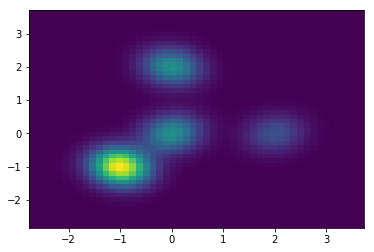

In [5]:
plt.hist2d(data[:, 0], data[:, 1], bins=50)

In [6]:
from vae.training import VariationalAutoEncoder

rdd = sc.parallelize(data)

model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=3, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=0.5, max_beta=1, distribution='normal', serial_layering=[2, 1])\
    .train_from_rdd(rdd, epochs=1)

beta: 0.9966310265004572
number of hidden layers: 2
loss=5.631545543670654, avg_feature_loss=5.610076427459717, avg_latent_loss=0.021469051018357277
running batch 0 (epoch 0)


beta: 0.9957926196993844
number of hidden layers: 2
loss=2.8783555030822754, avg_feature_loss=2.155075788497925, avg_latent_loss=0.723279595375061
running batch 1000 (epoch 0)


beta: 0.9947455659724211
number of hidden layers: 2
loss=2.408865451812744, avg_feature_loss=1.3725242614746094, avg_latent_loss=1.0363413095474243
running batch 2000 (epoch 0)


beta: 0.9934379411943964
number of hidden layers: 2
loss=2.179086446762085, avg_feature_loss=1.0654194355010986, avg_latent_loss=1.1136670112609863
running batch 3000 (epoch 0)


beta: 0.991804899339836
number of hidden layers: 2
loss=2.0188236236572266, avg_feature_loss=0.9157649278640747, avg_latent_loss=1.1030585765838623
running batch 4000 (epoch 0)


beta: 0.9897654567232967
number of hidden layers: 2
loss=2.2702791690826416, avg_feature_loss=1.0808827877044678, avg_latent_loss=1.1893963813781738
running batch 5000 (epoch 0)


beta: 0.9872184759618785
number of hidden layers: 2
loss=2.2247977256774902, avg_feature_loss=1.1576181650161743, avg_latent_loss=1.067179560661316
running batch 6000 (epoch 0)


beta: 0.9840376505018111
number of hidden layers: 2
loss=2.403707265853882, avg_feature_loss=1.298302173614502, avg_latent_loss=1.1054050922393799
running batch 7000 (epoch 0)


beta: 0.98006524098829
number of hidden layers: 2
loss=1.9689512252807617, avg_feature_loss=0.6320372223854065, avg_latent_loss=1.3369139432907104
running batch 8000 (epoch 0)


beta: 0.9751042528607683
number of hidden layers: 2
loss=2.0666372776031494, avg_feature_loss=0.7542762160301208, avg_latent_loss=1.3123610019683838
running batch 9000 (epoch 0)


beta: 0.9689086672551954
number of hidden layers: 2
loss=1.8306124210357666, avg_feature_loss=0.5124520063400269, avg_latent_loss=1.3181604146957397
running batch 10000 (epoch 0)


beta: 0.9611712407568264
number of hidden layers: 2
loss=2.116722822189331, avg_feature_loss=0.8497439622879028, avg_latent_loss=1.2669788599014282
running batch 11000 (epoch 0)


initializing encoder layer...
initializing encoder layer...
initializing encoder layer...
initializing encoder mu...
initializing encoder sigma...
initializing decoder layer...
initializing decoder layer...
initializing decoder layer...
initializing decoder output...


beta: 0.9515082689848259
number of hidden layers: 3
loss=2.6535844802856445, avg_feature_loss=1.981598973274231, avg_latent_loss=0.6719855666160583
running batch 12000 (epoch 0)


beta: 0.9394405584241943
number of hidden layers: 3
loss=2.6772732734680176, avg_feature_loss=2.03711199760437, avg_latent_loss=0.6401612162590027
running batch 13000 (epoch 0)


beta: 0.9243696628848781
number of hidden layers: 3
loss=2.4791173934936523, avg_feature_loss=1.4520480632781982, avg_latent_loss=1.0270692110061646
running batch 14000 (epoch 0)


beta: 0.9055482061374855
number of hidden layers: 3
loss=2.0175628662109375, avg_feature_loss=0.7644762992858887, avg_latent_loss=1.2530864477157593
running batch 15000 (epoch 0)


beta: 0.882042819004397
number of hidden layers: 3
loss=2.044633626937866, avg_feature_loss=0.8163697123527527, avg_latent_loss=1.2282639741897583
running batch 16000 (epoch 0)


beta: 0.8526878529307473
number of hidden layers: 3
loss=1.7550852298736572, avg_feature_loss=0.6088226437568665, avg_latent_loss=1.1462626457214355
running batch 17000 (epoch 0)


beta: 0.8160275746589603
number of hidden layers: 3
loss=1.908025860786438, avg_feature_loss=0.7492116689682007, avg_latent_loss=1.1588141918182373
running batch 18000 (epoch 0)


beta: 0.7702439754003906
number of hidden layers: 3
loss=1.783050537109375, avg_feature_loss=0.6048862338066101, avg_latent_loss=1.1781642436981201
running batch 19000 (epoch 0)


beta: 0.7130666145105136
number of hidden layers: 3
loss=1.6596599817276, avg_feature_loss=0.5647861957550049, avg_latent_loss=1.0948737859725952
running batch 20000 (epoch 0)


beta: 0.6416600267525775
number of hidden layers: 3
loss=1.562162160873413, avg_feature_loss=0.6673003435134888, avg_latent_loss=0.8948617577552795
running batch 21000 (epoch 0)


beta: 0.5524831095973372
number of hidden layers: 3
loss=1.3950315713882446, avg_feature_loss=0.5205615162849426, avg_latent_loss=0.874470055103302
running batch 22000 (epoch 0)


incomplete batch: (0,)
evaluating model...


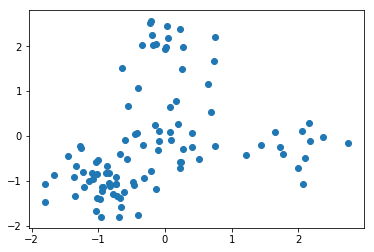

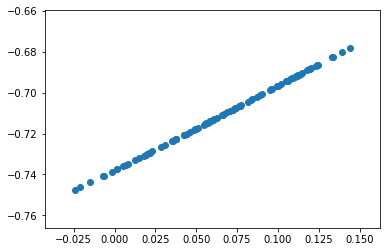

0 4.585367 4.3266387 0.25872874


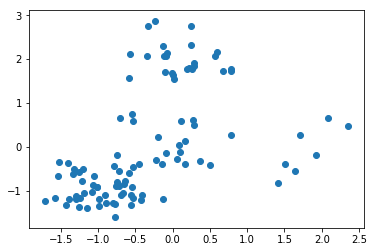

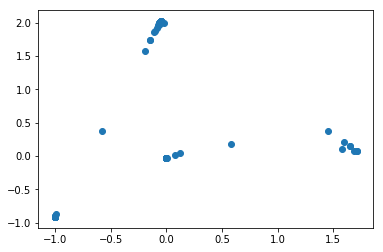

7500 2.0510778 0.71018744 1.3408904


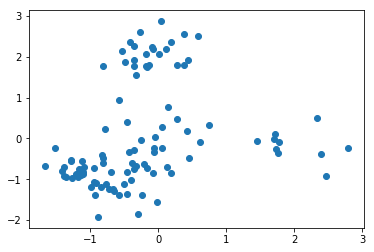

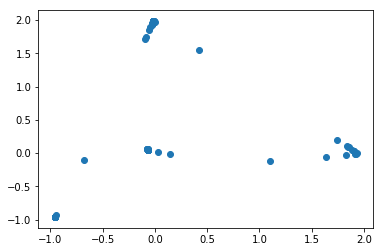

15000 2.134606 0.6936631 1.4409426


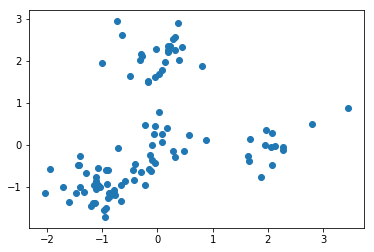

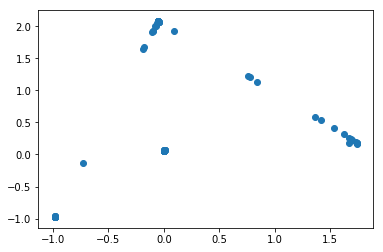

22499 2.0768623 0.69745946 1.3794028
initializing encoder layer...
initializing encoder layer...
initializing encoder layer...
initializing encoder mu...
initializing encoder sigma...
initializing decoder layer...
initializing decoder layer...
initializing decoder layer...
initializing decoder output...


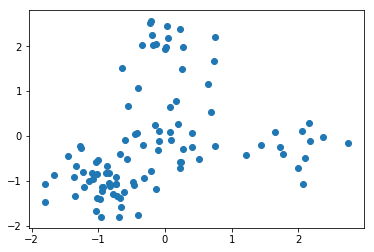

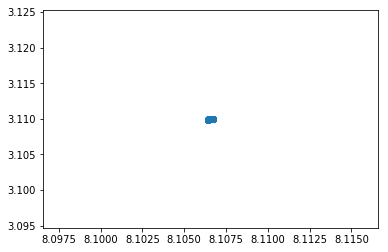

0 220.867 190.59647 30.270535


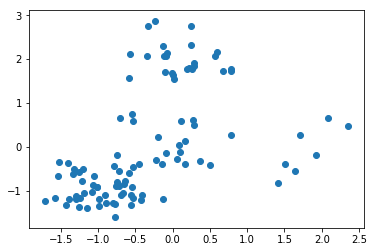

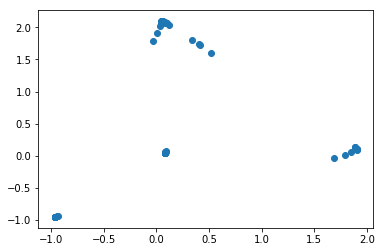

7500 1.9128462 0.55800307 1.3548431


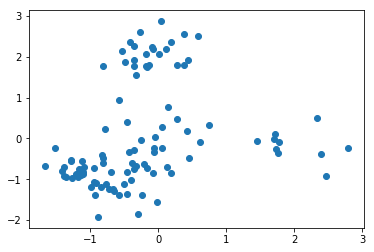

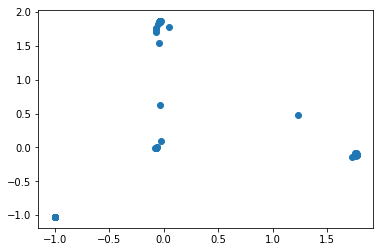

15000 1.8767642 0.54131496 1.3354492


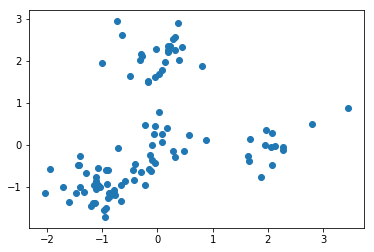

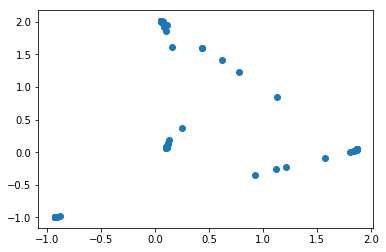

22499 2.2992907 1.0731846 1.2261062


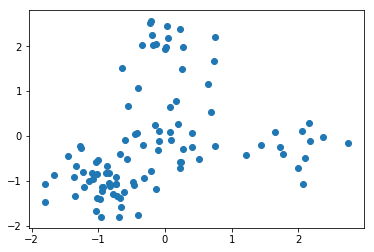

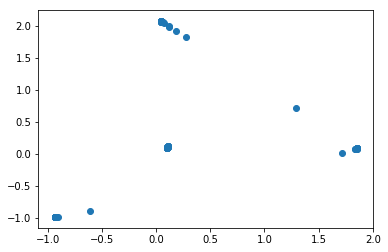

0 1.71664 0.52026254 1.1963775


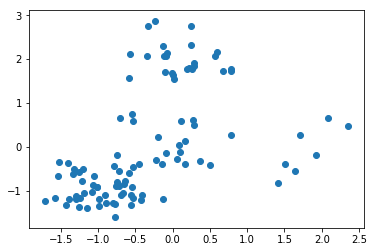

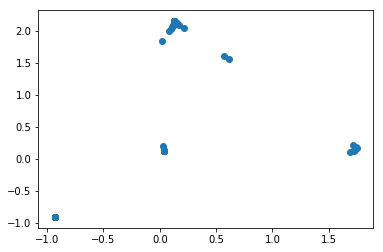

7500 1.731767 0.46117187 1.2705952


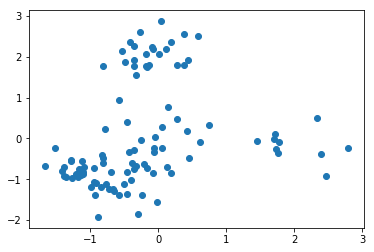

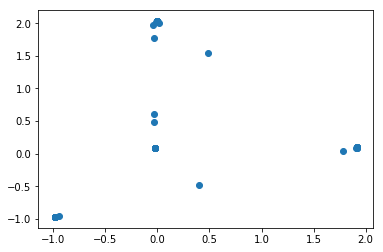

15000 1.9058783 0.93028045 0.97559786


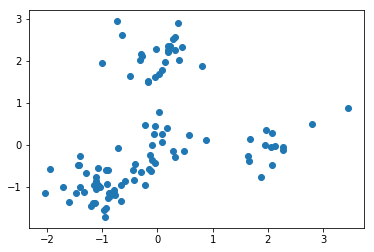

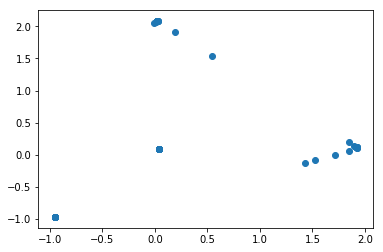

22499 1.380122 0.59450114 0.78562087


In [7]:
model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=3, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.05, batch_size=100, 
                               min_beta=0.5, max_beta=1, distribution='normal', serial_layering=[2,1])\
    .train(data, epochs=3, visualize=True)

(array([4.88076e+05, 1.04570e+04, 4.41000e+02, 1.63000e+02, 9.00000e+01,
        8.10000e+01, 6.30000e+01, 4.90000e+01, 4.00000e+01, 3.40000e+01,
        4.00000e+01, 2.00000e+01, 2.20000e+01, 3.40000e+01, 2.20000e+01,
        1.80000e+01, 1.50000e+01, 2.50000e+01, 1.60000e+01, 1.30000e+01,
        9.00000e+00, 1.30000e+01, 1.30000e+01, 1.50000e+01, 1.40000e+01,
        1.20000e+01, 1.80000e+01, 1.20000e+01, 1.10000e+01, 2.00000e+01,
        1.00000e+01, 1.50000e+01, 1.70000e+01, 1.60000e+01, 2.10000e+01,
        3.00000e+01, 2.80000e+01, 5.50000e+01, 1.80000e+02, 3.34850e+05,
        1.64999e+05, 1.50000e+01, 1.10000e+01, 8.00000e+00, 2.00000e+00,
        2.00000e+00, 1.00000e+00, 5.00000e+00, 1.00000e+00, 1.00000e+00,
        3.00000e+00, 3.00000e+00, 2.00000e+00, 4.00000e+00, 5.00000e+00,
        3.00000e+00, 6.00000e+00, 1.60000e+01, 1.80000e+01, 2.49912e+05,
        2.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

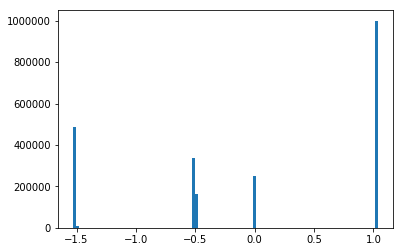

In [8]:
encoded_sample = model.project(data)
plt.hist(encoded_sample, bins=100)

In [24]:
vec_sample = np.array(rdd.sample(False, 0.01).collect())
encoded_sample = model.project(vec_sample)

# decoded_sample = data
decoded_sample = model.decode(encoded_sample)
decoded_sample.shape

(22382, 3)

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

encoded_x_sample = encoded_sample[:,0].reshape(-1,1)
dencoded_y_sample = decoded_sample[:,0].reshape(-1,1)

for i in range(2, 10):
  z_train, z_test, x_train, x_test = train_test_split(encoded_x_sample, dencoded_y_sample, test_size=0.4)
  gmm = GaussianMixture(i).fit(z_train)
  bic = gmm.bic(z_test)
  labels = gmm.predict(z_test)
  ss = silhouette_score(x_test, labels)
  print(i, bic, ss)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 37590)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pyspark/serializers.py", line 685, in read_int
    raise EOFError
EOFError
----------------------------------------


2 23296.37962215532 0.4114414408458438


3 -46643.95653532716 0.47713465175794756


4 -66896.65010865554 0.9992168035882828


5 -69962.31836753603 0.9429721420021615


6 -75902.37625336196 0.9845164810469424


7 -75575.33207598803 0.9835009020869112


8 -61521.10159948705 0.9453175823502861


9 -71541.75755199054 0.9794282026503437


In [31]:
a = np.append(labels.reshape(-1,1), x_test, axis=1)

In [38]:
np.where()

(array([   0,    0,    1, ..., 9012, 9013, 9013]),
 array([0, 1, 0, ..., 1, 0, 1]))